In [1]:
%matplotlib inline

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
# Load dataset
dataroot = r'E:\New data'

In [3]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

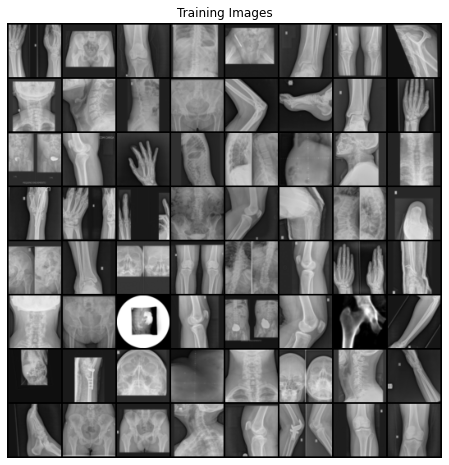

In [4]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                              #  transforms.Grayscale(1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.001, betas=(beta1, 0.999))

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 800

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device) # 64 = batchSize
        # print("label " + str(label.size()))
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1) # 256??
        # print("output " + str(output.size()))
        # Calculate loss on all-real batch
        errD_real = criterion(output, label.float())
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # print("fake " + str(fake.size()))
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label.float())
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label.float())
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/800][0/7]	Loss_D: 1.7299	Loss_G: 5.5258	D(x): 0.5446	D(G(z)): 0.5655 / 0.0061
[1/800][0/7]	Loss_D: 5.0439	Loss_G: 10.9245	D(x): 0.4412	D(G(z)): 0.9706 / 0.0000
[2/800][0/7]	Loss_D: 4.9187	Loss_G: 13.4339	D(x): 0.4230	D(G(z)): 0.9645 / 0.0000
[3/800][0/7]	Loss_D: 3.4534	Loss_G: 13.7528	D(x): 0.6004	D(G(z)): 0.9063 / 0.0000
[4/800][0/7]	Loss_D: 1.4032	Loss_G: 9.5501	D(x): 0.5287	D(G(z)): 0.2674 / 0.0001
[5/800][0/7]	Loss_D: 1.7265	Loss_G: 5.9094	D(x): 0.4707	D(G(z)): 0.3757 / 0.0036
[6/800][0/7]	Loss_D: 2.1208	Loss_G: 2.6512	D(x): 0.3963	D(G(z)): 0.4998 / 0.0939
[7/800][0/7]	Loss_D: 2.1676	Loss_G: 1.7614	D(x): 0.3858	D(G(z)): 0.5015 / 0.2367
[8/800][0/7]	Loss_D: 1.7012	Loss_G: 1.5459	D(x): 0.4332	D(G(z)): 0.4222 / 0.2663
[9/800][0/7]	Loss_D: 1.7123	Loss_G: 1.3288	D(x): 0.5332	D(G(z)): 0.5226 / 0.3254
[10/800][0/7]	Loss_D: 1.5626	Loss_G: 1.4453	D(x): 0.5013	D(G(z)): 0.4519 / 0.2736
[11/800][0/7]	Loss_D: 1.4422	Loss_G: 1.4700	D(x): 0.5395	D(G(z)): 0.4638 / 0.28

[100/800][0/7]	Loss_D: 1.2054	Loss_G: 1.0335	D(x): 0.5054	D(G(z)): 0.3255 / 0.3934
[101/800][0/7]	Loss_D: 1.2058	Loss_G: 0.9373	D(x): 0.4962	D(G(z)): 0.3290 / 0.4185
[102/800][0/7]	Loss_D: 1.2173	Loss_G: 1.0911	D(x): 0.5393	D(G(z)): 0.4049 / 0.3653
[103/800][0/7]	Loss_D: 1.0867	Loss_G: 1.3362	D(x): 0.6439	D(G(z)): 0.4531 / 0.3046
[104/800][0/7]	Loss_D: 1.1150	Loss_G: 1.2910	D(x): 0.6062	D(G(z)): 0.4271 / 0.3128
[105/800][0/7]	Loss_D: 1.2942	Loss_G: 0.8528	D(x): 0.5143	D(G(z)): 0.4056 / 0.4558
[106/800][0/7]	Loss_D: 1.2209	Loss_G: 0.9711	D(x): 0.4860	D(G(z)): 0.3495 / 0.4095
[107/800][0/7]	Loss_D: 1.2585	Loss_G: 1.0741	D(x): 0.4860	D(G(z)): 0.3703 / 0.3679
[108/800][0/7]	Loss_D: 1.1077	Loss_G: 1.5388	D(x): 0.6183	D(G(z)): 0.4318 / 0.2521
[109/800][0/7]	Loss_D: 1.1790	Loss_G: 1.1520	D(x): 0.5811	D(G(z)): 0.4295 / 0.3479
[110/800][0/7]	Loss_D: 1.2261	Loss_G: 1.3472	D(x): 0.6671	D(G(z)): 0.5162 / 0.2985
[111/800][0/7]	Loss_D: 1.1936	Loss_G: 1.3681	D(x): 0.6900	D(G(z)): 0.5244 / 0.2912
[112

[199/800][0/7]	Loss_D: 1.0626	Loss_G: 1.7218	D(x): 0.7305	D(G(z)): 0.5021 / 0.2038
[200/800][0/7]	Loss_D: 0.9344	Loss_G: 1.6074	D(x): 0.6757	D(G(z)): 0.3899 / 0.2375
[201/800][0/7]	Loss_D: 1.0368	Loss_G: 1.2224	D(x): 0.5831	D(G(z)): 0.3499 / 0.3189
[202/800][0/7]	Loss_D: 1.1112	Loss_G: 1.1803	D(x): 0.5720	D(G(z)): 0.3877 / 0.3329
[203/800][0/7]	Loss_D: 0.9943	Loss_G: 1.4326	D(x): 0.6471	D(G(z)): 0.3975 / 0.2693
[204/800][0/7]	Loss_D: 1.2152	Loss_G: 0.8465	D(x): 0.4254	D(G(z)): 0.2235 / 0.4790
[205/800][0/7]	Loss_D: 1.0446	Loss_G: 1.0155	D(x): 0.5430	D(G(z)): 0.2962 / 0.3972
[206/800][0/7]	Loss_D: 1.0156	Loss_G: 1.8500	D(x): 0.7205	D(G(z)): 0.4629 / 0.1790
[207/800][0/7]	Loss_D: 1.0727	Loss_G: 1.1325	D(x): 0.5328	D(G(z)): 0.3060 / 0.3530
[208/800][0/7]	Loss_D: 1.0835	Loss_G: 0.9635	D(x): 0.5046	D(G(z)): 0.2647 / 0.4055
[209/800][0/7]	Loss_D: 0.9852	Loss_G: 1.1978	D(x): 0.5847	D(G(z)): 0.3177 / 0.3325
[210/800][0/7]	Loss_D: 0.8753	Loss_G: 1.3657	D(x): 0.6422	D(G(z)): 0.3249 / 0.2765
[211

[298/800][0/7]	Loss_D: 0.9204	Loss_G: 1.1958	D(x): 0.4883	D(G(z)): 0.1162 / 0.3699
[299/800][0/7]	Loss_D: 0.6402	Loss_G: 1.7717	D(x): 0.6709	D(G(z)): 0.1907 / 0.2116
[300/800][0/7]	Loss_D: 0.6559	Loss_G: 1.8771	D(x): 0.6887	D(G(z)): 0.2166 / 0.1933
[301/800][0/7]	Loss_D: 0.5667	Loss_G: 2.4886	D(x): 0.7966	D(G(z)): 0.2679 / 0.1260
[302/800][0/7]	Loss_D: 0.8252	Loss_G: 1.4837	D(x): 0.6025	D(G(z)): 0.2103 / 0.2684
[303/800][0/7]	Loss_D: 0.8796	Loss_G: 2.3256	D(x): 0.8481	D(G(z)): 0.4726 / 0.1410
[304/800][0/7]	Loss_D: 0.6957	Loss_G: 2.2132	D(x): 0.8398	D(G(z)): 0.3718 / 0.1324
[305/800][0/7]	Loss_D: 0.5923	Loss_G: 2.1336	D(x): 0.7251	D(G(z)): 0.2138 / 0.1386
[306/800][0/7]	Loss_D: 0.5396	Loss_G: 1.8026	D(x): 0.7251	D(G(z)): 0.1712 / 0.1956
[307/800][0/7]	Loss_D: 0.6467	Loss_G: 1.4531	D(x): 0.6706	D(G(z)): 0.1939 / 0.2642
[308/800][0/7]	Loss_D: 0.7840	Loss_G: 1.3440	D(x): 0.5643	D(G(z)): 0.1533 / 0.3290
[309/800][0/7]	Loss_D: 0.6502	Loss_G: 2.5994	D(x): 0.8108	D(G(z)): 0.3200 / 0.0995
[310

[397/800][0/7]	Loss_D: 0.2875	Loss_G: 3.0929	D(x): 0.9171	D(G(z)): 0.1725 / 0.0632
[398/800][0/7]	Loss_D: 0.2220	Loss_G: 3.3536	D(x): 0.8925	D(G(z)): 0.0954 / 0.0518
[399/800][0/7]	Loss_D: 0.4244	Loss_G: 4.6878	D(x): 0.9598	D(G(z)): 0.2952 / 0.0147
[400/800][0/7]	Loss_D: 0.7374	Loss_G: 2.2645	D(x): 0.6048	D(G(z)): 0.0983 / 0.1589
[401/800][0/7]	Loss_D: 0.5010	Loss_G: 3.6401	D(x): 0.8979	D(G(z)): 0.2865 / 0.0427
[402/800][0/7]	Loss_D: 0.3670	Loss_G: 3.3779	D(x): 0.9048	D(G(z)): 0.2163 / 0.0485
[403/800][0/7]	Loss_D: 0.2857	Loss_G: 3.0051	D(x): 0.8699	D(G(z)): 0.1244 / 0.0737
[404/800][0/7]	Loss_D: 0.2935	Loss_G: 2.8725	D(x): 0.8972	D(G(z)): 0.1581 / 0.0806
[405/800][0/7]	Loss_D: 0.2709	Loss_G: 3.0491	D(x): 0.9203	D(G(z)): 0.1620 / 0.0637
[406/800][0/7]	Loss_D: 0.2503	Loss_G: 2.8217	D(x): 0.8690	D(G(z)): 0.0962 / 0.0875
[407/800][0/7]	Loss_D: 0.2725	Loss_G: 3.0763	D(x): 0.8954	D(G(z)): 0.1307 / 0.0619
[408/800][0/7]	Loss_D: 0.2685	Loss_G: 3.4375	D(x): 0.9447	D(G(z)): 0.1793 / 0.0426
[409

[496/800][0/7]	Loss_D: 0.1930	Loss_G: 2.1362	D(x): 0.8518	D(G(z)): 0.0277 / 0.1571
[497/800][0/7]	Loss_D: 0.2201	Loss_G: 3.1985	D(x): 0.8580	D(G(z)): 0.0555 / 0.0664
[498/800][0/7]	Loss_D: 0.1590	Loss_G: 3.4082	D(x): 0.9133	D(G(z)): 0.0472 / 0.0509
[499/800][0/7]	Loss_D: 0.1210	Loss_G: 3.6952	D(x): 0.9619	D(G(z)): 0.0750 / 0.0351
[500/800][0/7]	Loss_D: 0.1300	Loss_G: 3.7399	D(x): 0.9532	D(G(z)): 0.0747 / 0.0357
[501/800][0/7]	Loss_D: 0.1039	Loss_G: 3.4764	D(x): 0.9440	D(G(z)): 0.0439 / 0.0452
[502/800][0/7]	Loss_D: 0.1139	Loss_G: 4.0812	D(x): 0.9589	D(G(z)): 0.0675 / 0.0243
[503/800][0/7]	Loss_D: 0.1274	Loss_G: 3.7823	D(x): 0.9457	D(G(z)): 0.0661 / 0.0313
[504/800][0/7]	Loss_D: 0.1040	Loss_G: 3.7233	D(x): 0.9516	D(G(z)): 0.0508 / 0.0369
[505/800][0/7]	Loss_D: 0.1603	Loss_G: 3.3950	D(x): 0.8915	D(G(z)): 0.0369 / 0.0551
[506/800][0/7]	Loss_D: 0.1344	Loss_G: 4.0093	D(x): 0.9665	D(G(z)): 0.0907 / 0.0275
[507/800][0/7]	Loss_D: 0.1125	Loss_G: 3.8322	D(x): 0.9588	D(G(z)): 0.0650 / 0.0297
[508

[595/800][0/7]	Loss_D: 0.0700	Loss_G: 4.3639	D(x): 0.9812	D(G(z)): 0.0463 / 0.0188
[596/800][0/7]	Loss_D: 0.1004	Loss_G: 4.5106	D(x): 0.9593	D(G(z)): 0.0528 / 0.0192
[597/800][0/7]	Loss_D: 0.0635	Loss_G: 4.3215	D(x): 0.9740	D(G(z)): 0.0355 / 0.0210
[598/800][0/7]	Loss_D: 0.0685	Loss_G: 4.1619	D(x): 0.9653	D(G(z)): 0.0302 / 0.0238
[599/800][0/7]	Loss_D: 0.0595	Loss_G: 4.5333	D(x): 0.9673	D(G(z)): 0.0249 / 0.0168
[600/800][0/7]	Loss_D: 0.0658	Loss_G: 4.2839	D(x): 0.9704	D(G(z)): 0.0334 / 0.0218
[601/800][0/7]	Loss_D: 0.0650	Loss_G: 4.1971	D(x): 0.9673	D(G(z)): 0.0306 / 0.0294
[602/800][0/7]	Loss_D: 0.0993	Loss_G: 4.7026	D(x): 0.9564	D(G(z)): 0.0363 / 0.0182
[603/800][0/7]	Loss_D: 0.0648	Loss_G: 4.1243	D(x): 0.9656	D(G(z)): 0.0284 / 0.0245
[604/800][0/7]	Loss_D: 0.1697	Loss_G: 6.6691	D(x): 0.9917	D(G(z)): 0.1374 / 0.0054
[605/800][0/7]	Loss_D: 2.6551	Loss_G: 6.4204	D(x): 0.7815	D(G(z)): 0.6364 / 0.0614
[606/800][0/7]	Loss_D: 1.1500	Loss_G: 2.6991	D(x): 0.6695	D(G(z)): 0.3370 / 0.1799
[607

[694/800][0/7]	Loss_D: 0.0314	Loss_G: 5.1956	D(x): 0.9836	D(G(z)): 0.0145 / 0.0107
[695/800][0/7]	Loss_D: 0.0532	Loss_G: 5.0940	D(x): 0.9843	D(G(z)): 0.0309 / 0.0096
[696/800][0/7]	Loss_D: 0.0474	Loss_G: 4.7544	D(x): 0.9692	D(G(z)): 0.0150 / 0.0143
[697/800][0/7]	Loss_D: 0.0366	Loss_G: 4.9212	D(x): 0.9790	D(G(z)): 0.0150 / 0.0140
[698/800][0/7]	Loss_D: 0.0329	Loss_G: 4.7390	D(x): 0.9842	D(G(z)): 0.0165 / 0.0149
[699/800][0/7]	Loss_D: 0.0379	Loss_G: 4.6778	D(x): 0.9756	D(G(z)): 0.0128 / 0.0166
[700/800][0/7]	Loss_D: 0.0522	Loss_G: 5.3221	D(x): 0.9872	D(G(z)): 0.0296 / 0.0102
[701/800][0/7]	Loss_D: 0.3222	Loss_G: 3.9096	D(x): 0.8589	D(G(z)): 0.0576 / 0.0828
[702/800][0/7]	Loss_D: 5.0141	Loss_G: 2.0172	D(x): 0.5981	D(G(z)): 0.4851 / 0.2804
[703/800][0/7]	Loss_D: 1.7334	Loss_G: 1.3371	D(x): 0.5189	D(G(z)): 0.4141 / 0.3722
[704/800][0/7]	Loss_D: 1.6548	Loss_G: 1.7300	D(x): 0.5573	D(G(z)): 0.4737 / 0.2788
[705/800][0/7]	Loss_D: 1.6367	Loss_G: 1.6753	D(x): 0.6327	D(G(z)): 0.5807 / 0.2947
[706

[793/800][0/7]	Loss_D: 0.0883	Loss_G: 4.0063	D(x): 0.9556	D(G(z)): 0.0403 / 0.0260
[794/800][0/7]	Loss_D: 0.0753	Loss_G: 3.9937	D(x): 0.9543	D(G(z)): 0.0272 / 0.0298
[795/800][0/7]	Loss_D: 0.1080	Loss_G: 3.6669	D(x): 0.9381	D(G(z)): 0.0393 / 0.0403
[796/800][0/7]	Loss_D: 0.0764	Loss_G: 4.3170	D(x): 0.9744	D(G(z)): 0.0475 / 0.0207
[797/800][0/7]	Loss_D: 0.0660	Loss_G: 4.1829	D(x): 0.9709	D(G(z)): 0.0350 / 0.0220
[798/800][0/7]	Loss_D: 0.0764	Loss_G: 4.3413	D(x): 0.9772	D(G(z)): 0.0491 / 0.0204
[799/800][0/7]	Loss_D: 0.0669	Loss_G: 4.1787	D(x): 0.9702	D(G(z)): 0.0350 / 0.0233


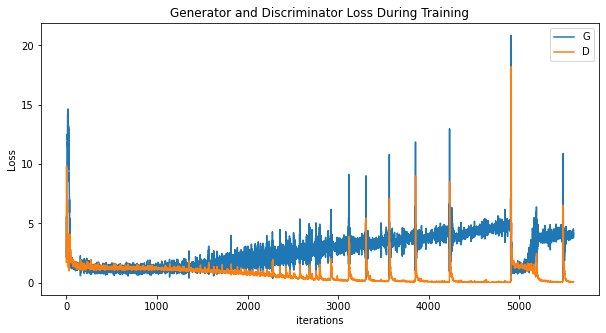

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

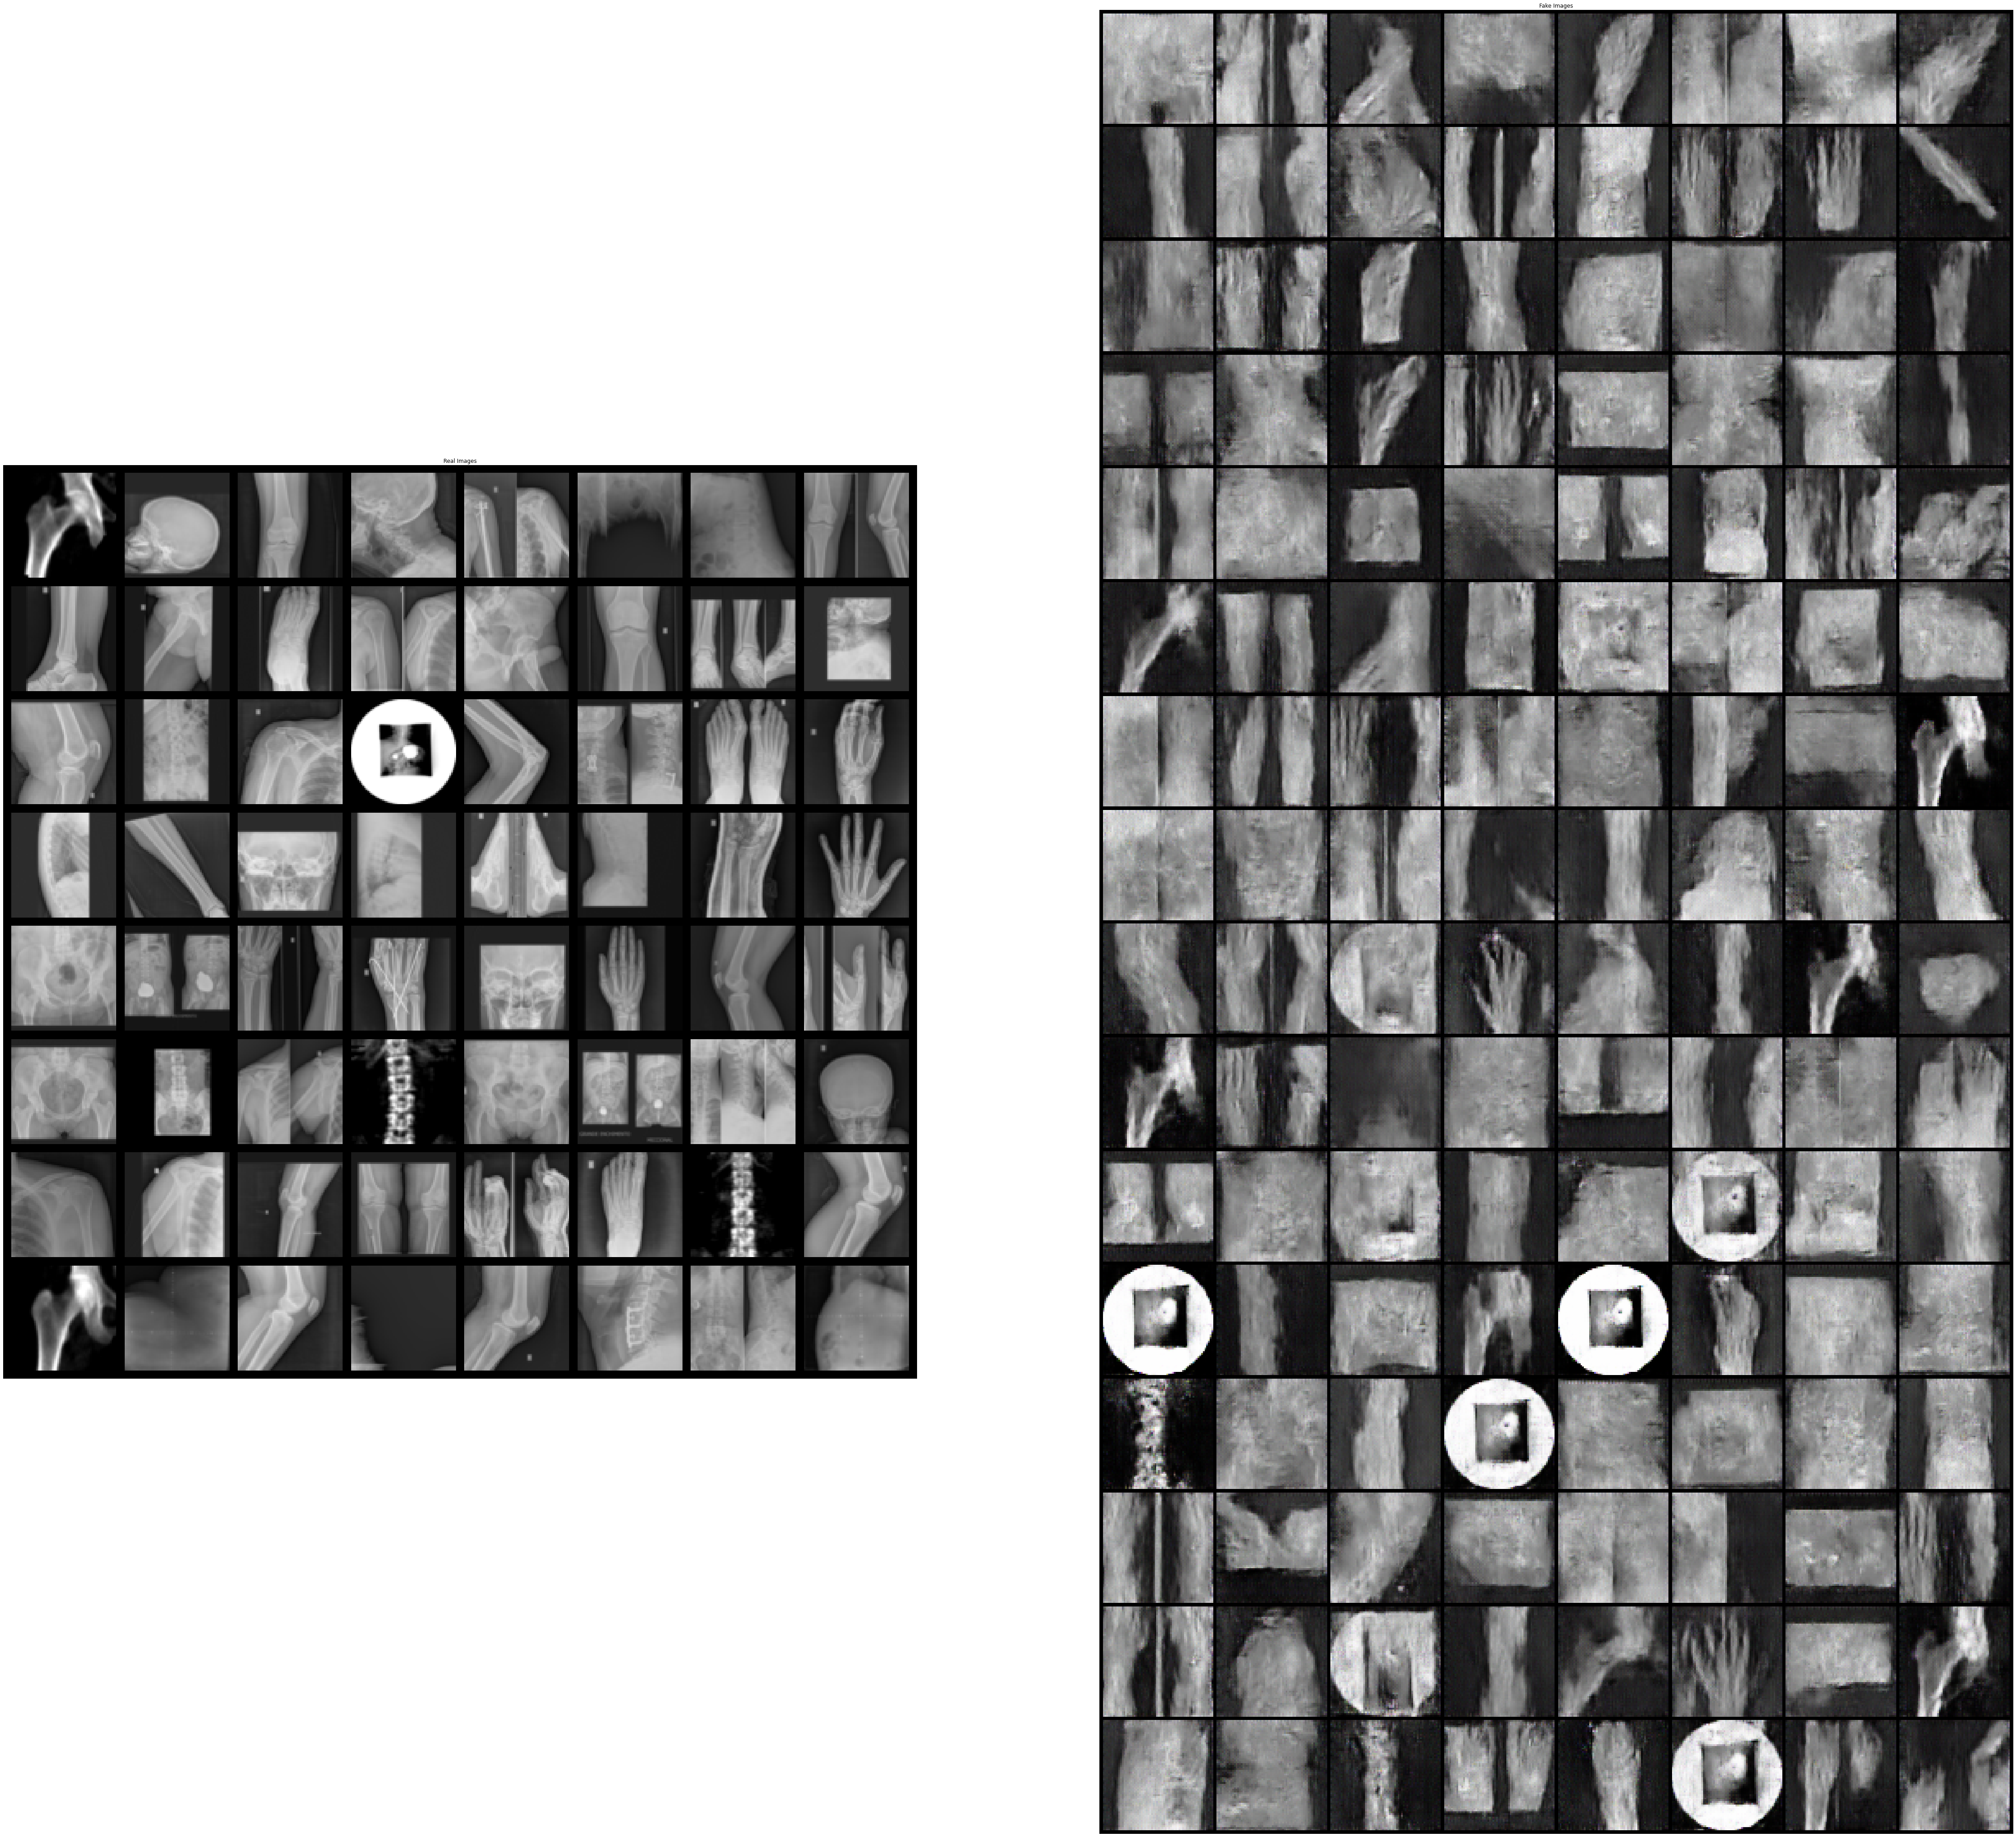

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(80,80))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [13]:
nimgs = len(img_list)
print(nimgs)

1


In [40]:
img_list

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4628,  ..., 0.4721, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.5174,  ..., 0.4772, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5076,  ..., 0.4908, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4798,  ..., 0.4843, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4844,  ...,

In [42]:
type(img_list)

list

In [43]:
len(img_list)

4

In [44]:
len(img_list(1))

TypeError: 'list' object is not callable

In [50]:
img_list[-1][0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2541,  ..., 0.5473, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3849,  ..., 0.3029, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [47]:
from PIL import Image

# assuming generated_images is a list of PIL Image objects
for i, img in enumerate(img_list):
    img.save(f'gan_{i}.png')

AttributeError: 'Tensor' object has no attribute 'save'

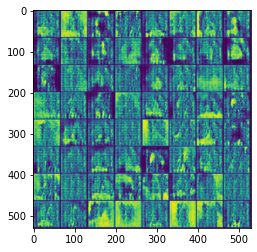

In [62]:
# import cv2

plt.imshow(img_list[3][0])

In [63]:
len(img_list)

4

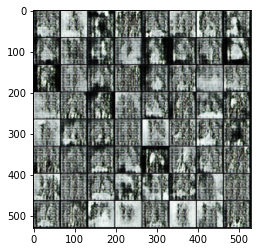

In [67]:
plt.imshow(np.transpose(img_list[3],(1,2,0)))

In [68]:
img_list[-1]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2541,  ..., 0.5473, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3849,  ..., 0.3029, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2856,  ..., 0.5643, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3155,  ..., 0.3792, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2725,  ..., 0.5896, 0.0000, 0.

In [69]:
len(img_list[-1])

3

In [71]:
with open("file.txt", "w") as f:
    for s in img_list[-1]:
        f.write(str(s) +"\n")

In [72]:
img=[]
with open("file.txt", "r") as f:
  for line in f:
    img.append(int(line.strip()))

ValueError: invalid literal for int() with base 10: 'tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],'

In [73]:
type(img_list[-1])

torch.Tensor

In [74]:
img_list_1 = img_list[-1].numpy()

In [75]:
img_list_1

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.2541468 , ..., 0.5472515 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.38491514, ..., 0.30287626,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.28556788, ..., 0.56425774,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.31547764, ..., 0.3792047 ,
         0.        , 0.        ],
        [0. 

In [76]:
type(img_list_1)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


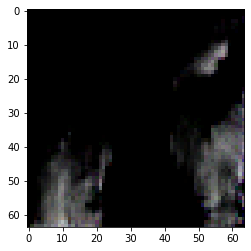

In [33]:
plt.imshow(np.transpose(fake[-1],(1,2,0)))

In [146]:
import cv2
import numpy as np
  
image = cv2.imread(r"C:\Users\D. RHUTHVIK\Desktop\Picture1.png")
  
cv2.imshow('Original Image', image)
cv2.waitKey(0)
  
# Gaussian Blur
Gaussian = cv2.GaussianBlur(image, (7, 7), 0)
cv2.imshow('Gaussian Blurring', Gaussian)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Load your original x-ray dataset
xray_data = np.load('xray_dataset.npy')
xray_labels = np.load('xray_labels.npy')

# Load your newly generated images in vector form
generated_data = np.load('generated_images.npy')
generated_labels = np.ones(len(generated_data)) # Assign label 1 to generated images

# Combine the original and generated images into a single dataset
combined_data = np.concatenate((xray_data, generated_data), axis=0)
combined_labels = np.concatenate((xray_labels, generated_labels), axis=0)

# Split the combined dataset into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

# Define the deep neural network model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training set
model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
from PIL import Image
import numpy as np

# Load your newly generated images in vector form
generated_data = np.load('generated_images.npy')

# Convert the generated images from vectors to PNG format and save them
for i in range(len(generated_data)):
    image_array = generated_data[i].reshape(64, 64) # Assuming the images are of size 64x64
    image = Image.fromarray((image_array * 255).astype(np.uint8), mode='L') # Convert back to grayscale image and scale to 0-255 range
    image.save(f'generated_image_{i}.png')


In [29]:
np.transpose(fake[5],(1,2,0)).type

<function Tensor.type>

In [30]:
fake.type

<function Tensor.type>

In [61]:
fake[0]

tensor([[[-0.4369, -0.3212, -0.3081],
         [-0.1716, -0.1528, -0.0633],
         [-0.0947, -0.0921, -0.0547],
         ...,
         [-0.1415, -0.1758, -0.1131],
         [-0.1133, -0.0624, -0.0547],
         [-0.1230, -0.0794,  0.0508]],

        [[-0.2162,  0.1316,  0.2087],
         [ 0.2196,  0.2704,  0.2650],
         [ 0.2103,  0.1619,  0.1351],
         ...,
         [ 0.0385,  0.1222,  0.1107],
         [ 0.1029,  0.0608,  0.0608],
         [ 0.0486,  0.0884,  0.1299]],

        [[-0.4701,  0.1092,  0.2254],
         [ 0.2731,  0.1816,  0.1981],
         [ 0.2159,  0.2526,  0.1631],
         ...,
         [ 0.1846,  0.1736,  0.1569],
         [ 0.1881,  0.2004,  0.1274],
         [ 0.2011,  0.1638,  0.1759]],

        ...,

        [[-0.7939, -0.7362, -0.8777],
         [-0.8399, -0.3746, -0.1144],
         [ 0.0884,  0.2018,  0.2340],
         ...,
         [ 0.3703,  0.3695,  0.3456],
         [ 0.2943,  0.2577,  0.2328],
         [ 0.1421,  0.1227,  0.0588]],

        [[

In [64]:
print((fake).shape)

torch.Size([64, 64, 64, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


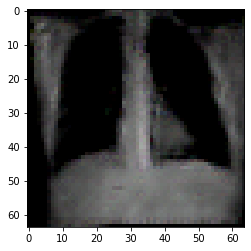

In [66]:
plt.imshow(np.transpose(fake[0],(1,2,0)))

In [76]:
import os
import cv2
import numpy as np

# Set the path to the folder where you want to save the images
save_path = r"E:\gennew"
numimg = 1
for i in range(64):
# Reshape the tensor object to the appropriate image shape
#     fake[i] = fake[i].reshape(numimg, 64, 64, 1)

# Convert the tensor object to a numpy array
    images = np.transpose(fake1[i],(1,2,0)).numpy()
    print (images)

# Loop over each image in the numpy array and save it to the appropriate folder
    # Create a unique name for the image based on the counter variable
    img_name = "img_" + str(i) + ".png"
    
    # Save the image to the appropriate folder using cv2.imwrite()
    cv2.imwrite(os.path.join(save_path, img_name), images[i])


[[[-0.43692046 -0.4179988  -0.41737923]
  [-0.32120508 -0.3094899  -0.3471251 ]
  [-0.3080909  -0.2795044  -0.27660894]
  ...
  [-0.49304867 -0.51728034 -0.5127875 ]
  [-0.53655875 -0.56658214 -0.5568661 ]
  [-0.41637868 -0.4360895  -0.44448364]]

 [[-0.2107047  -0.22808354 -0.20093526]
  [-0.09409034 -0.04490994 -0.0356889 ]
  [ 0.04666001  0.00098609  0.04792713]
  ...
  [-0.29680476 -0.27624723 -0.32148144]
  [-0.26757005 -0.29265916 -0.22557794]
  [-0.12359177 -0.14165735 -0.16363238]]

 [[-0.08025796 -0.12907343 -0.09823887]
  [ 0.16123517  0.16254333  0.13329254]
  [ 0.1599623   0.19553223  0.13949805]
  ...
  [-0.12304838 -0.10552395 -0.11440463]
  [-0.07942446 -0.07455436 -0.1001595 ]
  [ 0.05083933  0.05827688 -0.0232419 ]]

 ...

 [[-0.66864085 -0.7546684  -0.72563285]
  [-0.78336304 -0.7770175  -0.7107088 ]
  [-0.7495542  -0.76591945 -0.7634295 ]
  ...
  [ 0.16032606  0.16915281  0.16160862]
  [ 0.09033009  0.04121005  0.05141031]
  [-0.3568737  -0.3217708  -0.3654777 ]]

 [

[[[-0.10007881 -0.09250373 -0.07003844]
  [-0.16919497 -0.1757105  -0.14969116]
  [-0.24656947 -0.22847961 -0.19454491]
  ...
  [-0.14690267 -0.17565715 -0.16128254]
  [-0.12898116 -0.12292741 -0.1003824 ]
  [-0.16639392 -0.1601833  -0.13225575]]

 [[ 0.01072875 -0.03037063 -0.00900439]
  [-0.04078688 -0.04273942 -0.00977319]
  [-0.00814074 -0.02265817 -0.02624092]
  ...
  [ 0.02910218  0.02711176 -0.03079044]
  [ 0.01730345  0.00529478  0.03943915]
  [-0.04574183 -0.06048679 -0.04598426]]

 [[ 0.06595764  0.0325312   0.03014795]
  [ 0.03300257  0.00257156  0.04001272]
  [-0.03662452 -0.02165912  0.00377191]
  ...
  [ 0.0541042   0.05120249  0.05974727]
  [ 0.09818371  0.07900384  0.09360947]
  [ 0.07441641  0.0644049   0.02091392]]

 ...

 [[ 0.5629301   0.5386829   0.5435215 ]
  [ 0.53114766  0.5303023   0.55151117]
  [ 0.55000186  0.56033665  0.54074544]
  ...
  [ 0.16453968  0.20485686  0.13128601]
  [ 0.13041267  0.10139672  0.14350352]
  [-0.02633017 -0.00115314 -0.01994152]]

 [

In [70]:
fake1= fake1.reshape(64, 0, 64, 64)

RuntimeError: shape '[64, 0, 64, 64]' is invalid for input of size 786432

In [68]:
fake1=fake

In [71]:
for i in range(64):
    fake1[i] = np.transpose(fake1[i],(1,2,0))

RuntimeError: The expanded size of the tensor (64) must match the existing size (3) at non-singleton dimension 2.  Target sizes: [3, 64, 64].  Tensor sizes: [64, 64, 3]

In [72]:
fake.shape


torch.Size([64, 3, 64, 64])

In [81]:
cv2.imshow("img1", np.transpose(fake1[63],(1,2,0)))

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


In [83]:
type(np.transpose(fake1[1],(1,2,0)))

torch.Tensor

In [91]:

cv2.imshow("img1", np.array(np.transpose(fake1[1],(1,2,0))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


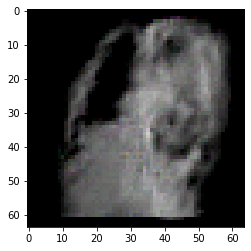

In [89]:
plt.imshow(np.transpose(fake1[1],(1,2,0)))

In [1]:
print(fake1[1])

NameError: name 'fake1' is not defined